In [3]:
import numpy as np
import cv2
import os
import re
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:

# -------------------- Utility function ------------------------
def normalize_label(str_):
    str_ = str_.replace(" ", "")
    str_ = str_.translate(str_.maketrans("","", "()"))
    str_ = str_.split("_")
    return ''.join(str_[:2])

def normalize_desc(folder, sub_folder):
    text = folder + " - " + sub_folder
    text = re.sub(r'\d+', '', text)
    text = text.replace(".", "")
    text = text.strip()
    return text

def print_progress(val, val_len, folder, sub_folder, filename, bar_size=10):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    print("[%s] folder : %s/%s/ ----> file : %s" % (progr, folder, sub_folder, filename))

# -------------------- Load Dataset ------------------------

dataset_dir = "/content/gdrive/My Drive/Colab Notebooks/out"

imgs = [] #list image matrix
labels = []
descs = []
for folder in os.listdir(dataset_dir):
    for sub_folder in os.listdir(os.path.join(dataset_dir, folder)):
        #if sub_folder == "schizophrenia":
        #    sub_folder= "healthy"
        #else:
        #    sub_folder= "schizophrenia"
        sub_folder_files = os.listdir(os.path.join(dataset_dir, folder, sub_folder))
        len_sub_folder = len(sub_folder_files) - 1

        for i, filename in enumerate(sub_folder_files):
            img = cv2.imread(os.path.join(dataset_dir, folder, sub_folder, filename))

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            h, w = gray.shape
            ymin, ymax, xmin, xmax = h//3, h*2//3, w//3, w*2//3
            crop = gray[ymin:ymax, xmin:xmax]

            resize = cv2.resize(crop, (0,0), fx=0.5, fy=0.5)

            imgs.append(gray)
            labels.append(sub_folder)
            descs.append(normalize_desc(folder, sub_folder))
            print_progress(i, len_sub_folder, folder, sub_folder, filename)

[          ] folder : out/healthy/ ----> file : CC4094.png
[          ] folder : out/healthy/ ----> file : CC1085.png
[          ] folder : out/healthy/ ----> file : CC2606.png
[          ] folder : out/healthy/ ----> file : CC3945.png
[          ] folder : out/healthy/ ----> file : CC0385.png
[          ] folder : out/healthy/ ----> file : CC3037.png
[          ] folder : out/healthy/ ----> file : CC1709.png
[#         ] folder : out/healthy/ ----> file : CC0325.png
[#         ] folder : out/healthy/ ----> file : CC0717.png
[#         ] folder : out/healthy/ ----> file : CC0239.png
[#         ] folder : out/healthy/ ----> file : CC2825.png
[#         ] folder : out/healthy/ ----> file : CC2442.png
[#         ] folder : out/healthy/ ----> file : CC0600.png
[#         ] folder : out/healthy/ ----> file : CC1960.png
[#         ] folder : out/healthy/ ----> file : CC1197.png
[#         ] folder : out/healthy/ ----> file : CC4183.png
[#         ] folder : out/healthy/ ----> file : CC1570.p

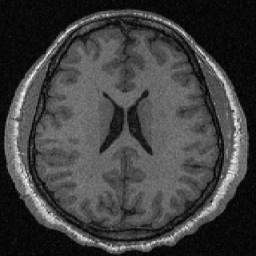

In [5]:
from google.colab.patches import cv2_imshow
cv2_imshow(imgs[5])

In [6]:
from skimage.feature import graycomatrix, graycoprops

# ----------------- calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135 ----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):

    glcm = graycomatrix(img,
                        distances=dists,
                        angles=agls,
                        levels=lvl,
                        symmetric=sym,
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in graycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label)
    #print(feature)
    return feature


# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
#properties = ['correlation']
glcm_all_agls = []
for img, label in zip(imgs, labels):
    glcm_all_agls.append(
            calc_glcm_all_agls(img,
                                label,
                                props=properties)
                            )

columns = []
angles = ['0', '45', '90','135']
for name in properties :
    for ang in angles:
        columns.append(name + "_" + ang)

columns.append("label")

In [7]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls,
                      columns = columns)

glcm_df.shape


(250, 25)

In [8]:
from skimage.feature import local_binary_pattern, hog
# Function to calculate HOG features for a single image
def calc_hog_feature(img, orientations=2, pixels_per_cell=(32, 32), cells_per_block=(8, 8)):
    # Calculate HOG features
    #hog_features, hog_image = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True)
    hog_features = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)
    # Rescale histogram for better display
    #hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Return HOG features
    return hog_features

# Calculate HOG features for all images
hog_all = [calc_hog_feature(img) for img in imgs]

# Convert HOG features to DataFrame
hog_df = pd.DataFrame(hog_all, columns=[f'hog_{i}' for i in range(len(hog_all[0]))])
hog_df['label'] = labels
hog_df.shape

(250, 129)

In [9]:
from skimage.feature import local_binary_pattern

from sklearn.preprocessing import StandardScaler
import pandas as pd
from skimage.feature import local_binary_pattern, hog
from skimage import exposure
import numpy as np
from scipy.stats import ttest_ind
# Function to calculate LBP features for a single image
def calc_lbp_feature(img, radius=1, n_points=96):
    lbp = local_binary_pattern(img, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    return hist

# Calculate LBP features for all images
lbp_all = [calc_lbp_feature(img) for img in imgs]

# Convert LBP features to DataFrame
lbp_df = pd.DataFrame(lbp_all, columns=[f'lbp_{i}' for i in range(len(lbp_all[0]))])
lbp_df['label'] = labels



# Concatenate LBP features with GLCM features
combined_df = pd.concat([hog_df.drop(columns=['label']),lbp_df.drop(columns=['label']),glcm_df], axis=1)
#combined_df = glcm_df
#combined_df = lbp_df
#combined_df = hog_df
#t_test_statistic, _ = ttest_ind(glcm_df, lbp_df)
print(combined_df)#,t_test_statistic)
#print(glcm_df, lbp_df, combined_df)

#combined_df= combined_df.swapaxes(0, 1)
#print(combined_df)

# Assuming 'label' is the target variable

X = combined_df.drop(columns=['label'])
y = combined_df['label']

#X = combined_df.drop(combined_df.index[-1])
#y = combined_df.iloc[-1]

# Scale the input data using StandardScaler
scaler_combined = StandardScaler()
X_scaled = scaler_combined.fit_transform(X.values)

        hog_0     hog_1     hog_2     hog_3     hog_4     hog_5     hog_6  \
0    0.017552  0.015080  0.081646  0.015452  0.211605  0.022282  0.197153   
1    0.016897  0.017474  0.085559  0.019981  0.205824  0.029663  0.183539   
2    0.022697  0.019161  0.020768  0.022731  0.114603  0.027914  0.135986   
3    0.030168  0.028771  0.027989  0.029373  0.167967  0.029658  0.153934   
4    0.025018  0.023939  0.052485  0.027336  0.200303  0.028604  0.172756   
..        ...       ...       ...       ...       ...       ...       ...   
245  0.035200  0.032011  0.073166  0.027402  0.204402  0.049335  0.136514   
246  0.015472  0.016558  0.070578  0.022404  0.205905  0.040595  0.162440   
247  0.021393  0.023425  0.052495  0.021215  0.204034  0.038147  0.095013   
248  0.025032  0.028189  0.028789  0.024555  0.039198  0.026871  0.071969   
249  0.015775  0.015755  0.042853  0.015252  0.181299  0.033378  0.129396   

        hog_7     hog_8     hog_9  ...  contrast_135     ASM_0    ASM_45  \

In [10]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import pandas as pd

# Assuming X and y are your features and target variable, respectively
# Assuming num_selected_features_combined is the number of features to select
num_selected_features_combined = 175
for i in (0.3,0.2):
  print(f"\nTest Size: {i}")
  # Perform train-test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=42)

  # Apply PCA
  if i == 0.3:
    num_selected_features_combined = 175
  if i == 0.2:
    num_selected_features_combined = 200
  pca = PCA(n_components=num_selected_features_combined)
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.transform(X_test)

  # Function to train and evaluate a classifier
  def train_and_evaluate_classifier(classifier, X_train, y_train, X_test, y_test):
      model = classifier
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      y_prob = model.predict_proba(X_test)
      auc_roc = roc_auc_score(y_test, y_prob[:, 1])
      accuracy = accuracy_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
      #recall = recall_score(y_test, y_pred, average='weighted')
      f1 = f1_score(y_test, y_pred, average='weighted')
      conf_matrix = confusion_matrix(y_test, y_pred)
      specificity = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])
      recall = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])
      print(f"\nPerfomance Metrics:")
      print(f"Accuracy: {accuracy:.2f}")
      print(f"Precision: {precision:.2f}")
      print(f"Sensitivity (Recall): {recall:.2f}")
      print(f"Specificity: {specificity:.2f}")
      print(f"F1 Score: {f1:.2f}")
      print(f"AUC-ROC Score: {auc_roc:.2f}")
      print(f"Confusion matrix:\n", conf_matrix)

  # Train and evaluate classifiers after PCA
  # Logistic Regression
  print("\nLogistic Regression:")
  train_and_evaluate_classifier(LogisticRegression(max_iter=100), X_train_pca,  y_train, X_test_pca, y_test)

  # Decision Tree
  print("\nDecision Tree:")
  train_and_evaluate_classifier(DecisionTreeClassifier(random_state=104), X_train_pca, y_train, X_test_pca, y_test)

  # Random Forest
  print("\nRandom Forest:")
  train_and_evaluate_classifier(RandomForestClassifier(n_estimators=10000, random_state=42), X_train_pca, y_train, X_test_pca, y_test)

  # Gradient Boosted Trees
  print("\nGradient Boosted Trees:")
  train_and_evaluate_classifier(GradientBoostingClassifier(n_estimators=100, random_state=59), X_train_pca, y_train, X_test_pca, y_test)

  # Extra Trees
  print("\nExtra Trees:")
  train_and_evaluate_classifier(ExtraTreesClassifier(n_estimators=1000, random_state=42), X_train_pca, y_train, X_test_pca, y_test)

  # AdaBoost
  print("\nAdaBoost:")
  train_and_evaluate_classifier(AdaBoostClassifier(n_estimators=50, random_state=42), X_train_pca, y_train, X_test_pca, y_test)

  # LightGBM
  #print("\nLightGBM:")
  #train_and_evaluate_classifier(LGBMClassifier(n_estimators=1000, random_state=42), X_train_pca, y_train, X_test_pca, y_test)

  # HistGradientBoosting
  print("\nHistGradientBoosting:")
  train_and_evaluate_classifier(HistGradientBoostingClassifier(max_iter=1000, random_state=42), X_train_pca, y_train, X_test_pca, y_test)




Test Size: 0.3

Logistic Regression:

Perfomance Metrics:
Accuracy: 0.64
Precision: 0.66
Sensitivity (Recall): 0.51
Specificity: 0.78
F1 Score: 0.63
AUC-ROC Score: 0.65
Confusion matrix:
 [[28  8]
 [19 20]]

Decision Tree:

Perfomance Metrics:
Accuracy: 0.48
Precision: 0.48
Sensitivity (Recall): 0.36
Specificity: 0.61
F1 Score: 0.47
AUC-ROC Score: 0.49
Confusion matrix:
 [[22 14]
 [25 14]]

Random Forest:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Perfomance Metrics:
Accuracy: 0.49
Precision: 0.51
Sensitivity (Recall): 0.18
Specificity: 0.83
F1 Score: 0.43
AUC-ROC Score: 0.57
Confusion matrix:
 [[30  6]
 [32  7]]

Gradient Boosted Trees:

Perfomance Metrics:
Accuracy: 0.49
Precision: 0.50
Sensitivity (Recall): 0.36
Specificity: 0.64
F1 Score: 0.48
AUC-ROC Score: 0.49
Confusion matrix:
 [[23 13]
 [25 14]]

Extra Trees:

Perfomance Metrics:
Accuracy: 0.53
Precision: 0.63
Sensitivity (Recall): 0.15
Specificity: 0.94
F1 Score: 0.45
AUC-ROC Score: 0.59
Confusion matrix:
 [[34  2]
 [33  6]]

AdaBoost:

Perfomance Metrics:
Accuracy: 0.57
Precision: 0.58
Sensitivity (Recall): 0.51
Specificity: 0.64
F1 Score: 0.57
AUC-ROC Score: 0.60
Confusion matrix:
 [[23 13]
 [19 20]]

HistGradientBoosting:

Perfomance Metrics:
Accuracy: 0.55
Precision: 0.56
Sensitivity (Recall): 0.44
Specificity: 0.67
F1 Score: 0.54
AUC-ROC Score: 0.61
Confusion matrix:
 [[24 12]
 [22 17]]

Test Size: 0.2

Logistic Regression:

Perfomance Metrics:
Accuracy: 0.62
Pre

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Perfomance Metrics:
Accuracy: 0.58
Precision: 0.58
Sensitivity (Recall): 0.39
Specificity: 0.74
F1 Score: 0.57
AUC-ROC Score: 0.57
Confusion matrix:
 [[20  7]
 [14  9]]

Random Forest:

Perfomance Metrics:
Accuracy: 0.56
Precision: 0.56
Sensitivity (Recall): 0.52
Specificity: 0.59
F1 Score: 0.56
AUC-ROC Score: 0.61
Confusion matrix:
 [[16 11]
 [11 12]]

Gradient Boosted Trees:

Perfomance Metrics:
Accuracy: 0.60
Precision: 0.60
Sensitivity (Recall): 0.48
Specificity: 0.70
F1 Score: 0.59
AUC-ROC Score: 0.58
Confusion matrix:
 [[19  8]
 [12 11]]

Extra Trees:

Perfomance Metrics:
Accuracy: 0.68
Precision: 0.68
Sensitivity (Recall): 0.57
Specificity: 0.78
F1 Score: 0.68
AUC-ROC Score: 0.70
Confusion matrix:
 [[21  6]
 [10 13]]

AdaBoost:

Perfomance Metrics:
Accuracy: 0.58
Precision: 0.58
Sensitivity (Recall): 0.43
Specificity: 0.70
F1 Score: 0.57
AUC-ROC Score: 0.56
Confusion matrix:
 [[19  8]
 [13 10]]

HistGradientBoosting:

Perfomance Metrics:
Accuracy: 0.60
Precision: 0.60
Sensitivi


Test Size: 0.3

Metrics for LogisticRegression:
Accuracy: 0.77
Precision: 0.79
Sensitivity (Recall): 0.67
Specificity: 0.89
F1 Score: 0.77
AUC-ROC Score: 0.88
Confusion matrix:
 [[32  4]
 [13 26]]

Metrics for DecisionTreeClassifier:
Accuracy: 0.77
Precision: 0.78
Sensitivity (Recall): 0.69
Specificity: 0.86
F1 Score: 0.77
AUC-ROC Score: 0.78
Confusion matrix:
 [[31  5]
 [12 27]]

Metrics for RandomForestClassifier:
Accuracy: 0.77
Precision: 0.79
Sensitivity (Recall): 0.67
Specificity: 0.89
F1 Score: 0.77
AUC-ROC Score: 0.86
Confusion matrix:
 [[32  4]
 [13 26]]

Metrics for GradientBoostingClassifier:
Accuracy: 0.83
Precision: 0.85
Sensitivity (Recall): 0.72
Specificity: 0.94
F1 Score: 0.82
AUC-ROC Score: 0.92
Confusion matrix:
 [[34  2]
 [11 28]]

Metrics for ExtraTreesClassifier:
Accuracy: 0.75
Precision: 0.76
Sensitivity (Recall): 0.67
Specificity: 0.83
F1 Score: 0.75
AUC-ROC Score: 0.83
Confusion matrix:
 [[30  6]
 [13 26]]

Metrics for AdaBoostClassifier:
Accuracy: 0.79
Precisio

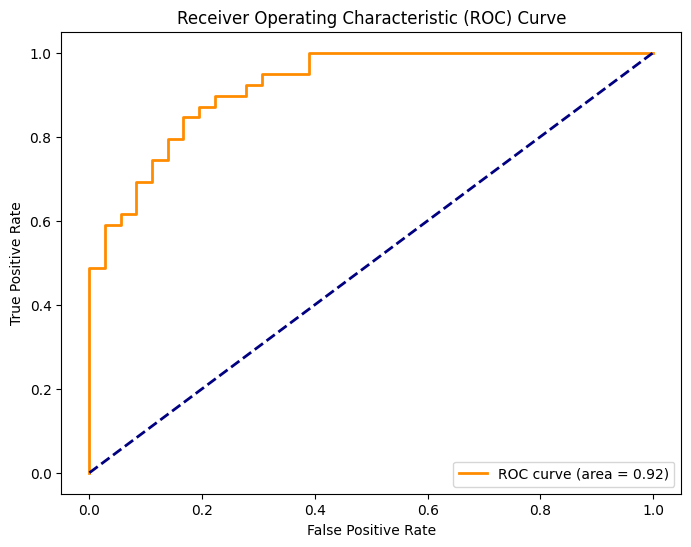

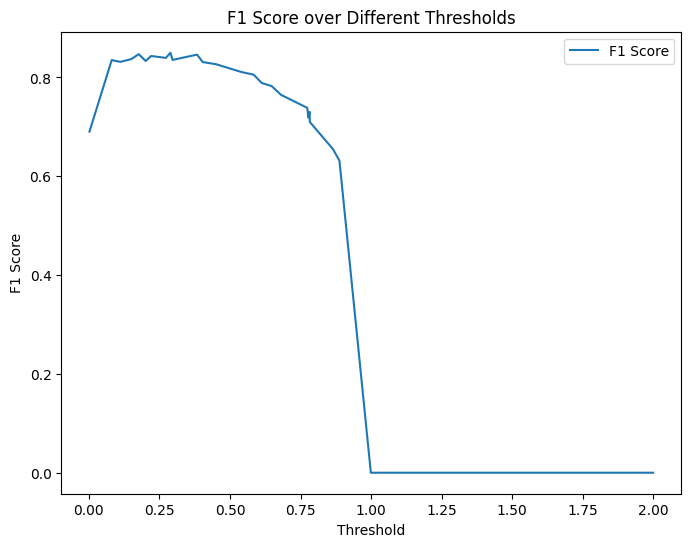


Test Size: 0.2

Metrics for LogisticRegression:
Accuracy: 0.82
Precision: 0.82
Sensitivity (Recall): 0.74
Specificity: 0.89
F1 Score: 0.82
AUC-ROC Score: 0.88
Confusion matrix:
 [[24  3]
 [ 6 17]]

Metrics for DecisionTreeClassifier:
Accuracy: 0.66
Precision: 0.66
Sensitivity (Recall): 0.52
Specificity: 0.78
F1 Score: 0.65
AUC-ROC Score: 0.65
Confusion matrix:
 [[21  6]
 [11 12]]

Metrics for RandomForestClassifier:
Accuracy: 0.78
Precision: 0.78
Sensitivity (Recall): 0.70
Specificity: 0.85
F1 Score: 0.78
AUC-ROC Score: 0.85
Confusion matrix:
 [[23  4]
 [ 7 16]]

Metrics for GradientBoostingClassifier:
Accuracy: 0.86
Precision: 0.86
Sensitivity (Recall): 0.83
Specificity: 0.89
F1 Score: 0.86
AUC-ROC Score: 0.95
Confusion matrix:
 [[24  3]
 [ 4 19]]

Metrics for ExtraTreesClassifier:
Accuracy: 0.82
Precision: 0.82
Sensitivity (Recall): 0.74
Specificity: 0.89
F1 Score: 0.82
AUC-ROC Score: 0.88
Confusion matrix:
 [[24  3]
 [ 6 17]]

Metrics for AdaBoostClassifier:
Accuracy: 0.82
Precisio

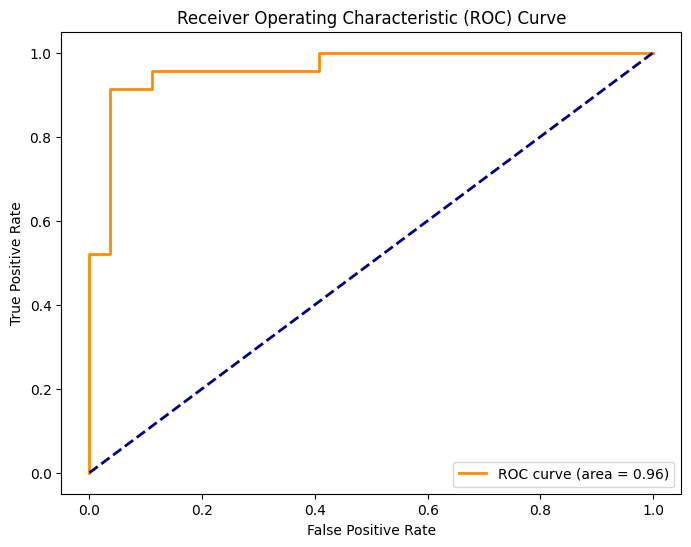

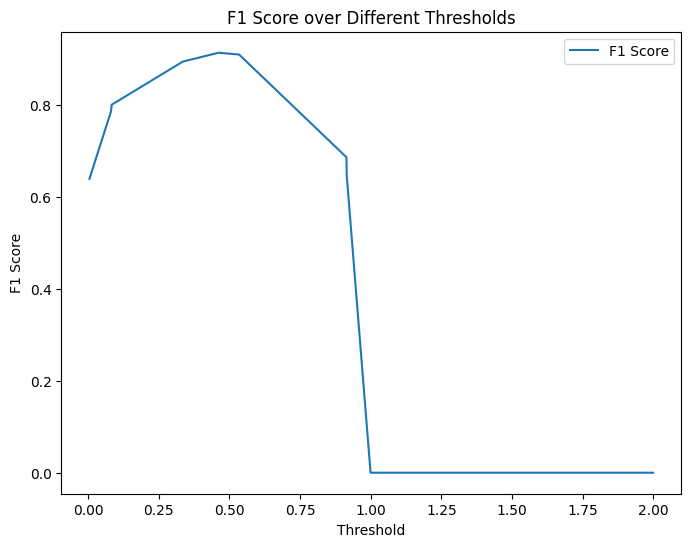

In [17]:

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier

#Encode string labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
for i in (0.3,0.2):
  print(f"\nTest Size: {i}")
  # Split the scaled data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(
      X_scaled, y_encoded, test_size=i, random_state=42
  )

  num_selected_features_combined = 250
  num_selected_features = num_selected_features_combined


  def train_evaluate_rfe(estimator,  X_train, y_train, X_test, y_test, num_selected_features, random_state=42, plot_roc=False, plot_f1=False):
      # Create the RFE model
      rfe = RFE(estimator, n_features_to_select=num_selected_features)

      # Fit the RFE model to the training data
      X_train_rfe = rfe.fit_transform(X_train, y_train)

      # Get the selected feature names
      selected_feature_names = X.columns[rfe.support_]

      # Convert X_train_rfe to a DataFrame with column names
      X_train_rfe_df = pd.DataFrame(X_train_rfe, columns=selected_feature_names)

      # Train the model using the selected features
      model = estimator
      model.fit(X_train_rfe_df.values, y_train)

      # Evaluate the model on the test set
      X_test_rfe = X_test[:, rfe.support_]
      y_pred = model.predict(X_test_rfe)

      # Predict probabilities for each class on the test set
      y_prob = model.predict_proba(X_test_rfe)

      fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])

      # Calculate AUC-ROC score for the positive class
      auc_roc = roc_auc_score(y_test, y_prob[:, 1])

      # Print metrics
      accuracy = accuracy_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
      #recall = recall_score(y_test, y_pred, average='weighted')
      f1 = f1_score(y_test, y_pred, average='weighted')
      conf_matrix = confusion_matrix(y_test, y_pred)
      # Handle the case when there are no true negatives
      if conf_matrix[0, 0] + conf_matrix[0, 1] != 0:
        specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
      else:
        specificity = 0.0
      recall = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])

      print(f"\nMetrics for {type(estimator).__name__}:")
      print(f"Accuracy: {accuracy:.2f}")
      print(f"Precision: {precision:.2f}")
      print(f"Sensitivity (Recall): {recall:.2f}")
      print(f"Specificity: {specificity:.2f}")
      print(f"F1 Score: {f1:.2f}")
      print(f"AUC-ROC Score: {auc_roc:.2f}")
      print(f"Confusion matrix:\n", conf_matrix)

      if plot_roc:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_roc))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

        # Plot F1 score over different thresholds
      if plot_f1:
        plt.figure(figsize=(8, 6))
        f1_scores = [f1_score(y_test, y_prob[:, 1] > threshold) for threshold in thresholds]
        plt.plot(thresholds, f1_scores, label='F1 Score')
        plt.xlabel('Threshold')
        plt.ylabel('F1 Score')
        plt.title('F1 Score over Different Thresholds')
        plt.legend()
        plt.show()
  # Create the RFE model with Logistic Regression as the estimator
  # Logistic Regression
  estimator_lr = LogisticRegression(max_iter=100)
  train_evaluate_rfe(estimator_lr, X_train,  y_train, X_test, y_test, num_selected_features_combined)

  # Decision Tree
  estimator_dt = DecisionTreeClassifier(random_state=104)
  train_evaluate_rfe(estimator_dt, X_train, y_train, X_test, y_test, num_selected_features_combined,random_state=104)

  # Random Forest
  estimator_rf = RandomForestClassifier(n_estimators=100, random_state=29)
  train_evaluate_rfe(estimator_rf, X_train, y_train, X_test, y_test, num_selected_features_combined,random_state=29)

  # Gradient Boosted Trees
  estimator_gb = GradientBoostingClassifier(n_estimators=100, random_state=59)
  train_evaluate_rfe(estimator_gb, X_train, y_train, X_test, y_test, num_selected_features_combined,random_state=59)

  # Extra Trees Classifier
  estimator_et = ExtraTreesClassifier(n_estimators=100, random_state=20)
  train_evaluate_rfe(estimator_et, X_train, y_train, X_test, y_test, num_selected_features_combined,random_state=20)

  # AdaBoost Classifier
  estimator_adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
  train_evaluate_rfe(estimator_adaboost, X_train, y_train, X_test, y_test, num_selected_features_combined)

  # HistGradientBoosting Classifier
  estimator_hist_gb = HistGradientBoostingClassifier(max_iter=100, random_state=42)
  train_evaluate_rfe(estimator_hist_gb, X_train, y_train, X_test, y_test, num_selected_features_combined, plot_roc=True, plot_f1=True)
